<a href="https://colab.research.google.com/github/mitsuhazuki/deep-image-prior/blob/master/project_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

In [1]:
# for local runtime only
%cd Desktop

C:\Users\Leon Herrington\Desktop


In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/mitsuhazuki/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 390 (delta 38), reused 7 (delta 0), pack-reused 289
Receiving objects: 100% (390/390), 193.16 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (193/193), done.
Updating files: 100% (58/58), done.


In [2]:
# for local runtime only
%cd deep-image-prior

C:\Users\Leon Herrington\Desktop\deep-image-prior


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libs

In [3]:
import pickle

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [5]:
## Fig 6
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
img_path  = 'data/inpainting/kate.png'
mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'


NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

# Load mask

In [6]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [7]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

In [9]:
# colab
pickle.dump( img_np, open( "/content/drive/MyDrive/Deep_Image_Prior/inpainting/img_np.p", "wb" ))
pickle.dump( img_mask_np, open( "/content/drive/MyDrive/Deep_Image_Prior/inpainting/img_mask_np.p", "wb" ))

In [47]:
# local runtime
pickle.dump( img_np, open( "projet/inpainting/img_np.p", "wb" ))
pickle.dump( img_mask_np, open( "projet/inpainting/img_mask_np.p", "wb" ))

### Visualize

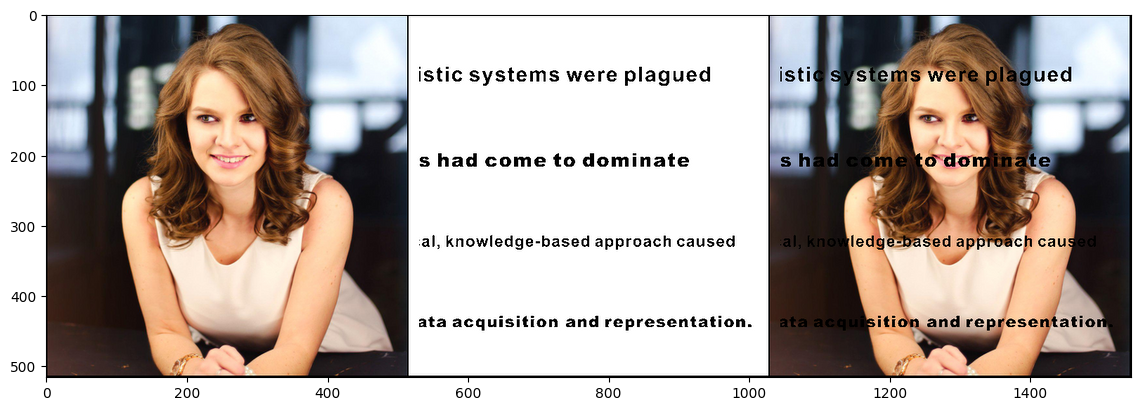

In [10]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Setup

In [11]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [12]:
INPUT = 'noise'
input_depth = 1

num_iter = 3001
show_every = 50
figsize = 8
reg_noise_std = 0.00
param_noise = True



In [13]:
# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

# Main loop

In [14]:
list_out_np = []

In [ ]:
list_out_np = pickle.load( open( "projet/inpainting/list_out_np.p", "rb" ))

Starting optimization with ADAM
 N0 Iteration 00000    Loss 0.119680

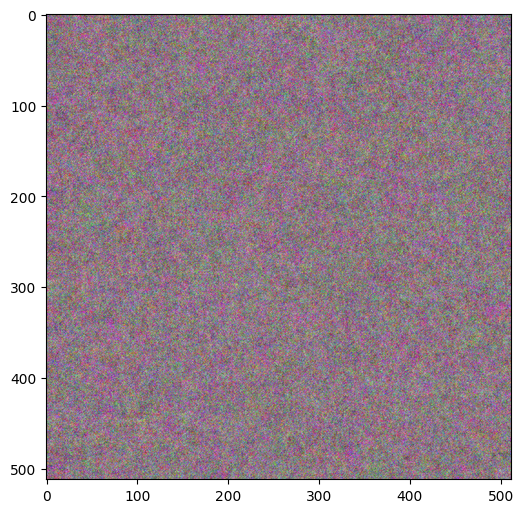

 N0 Iteration 00050    Loss 0.014048

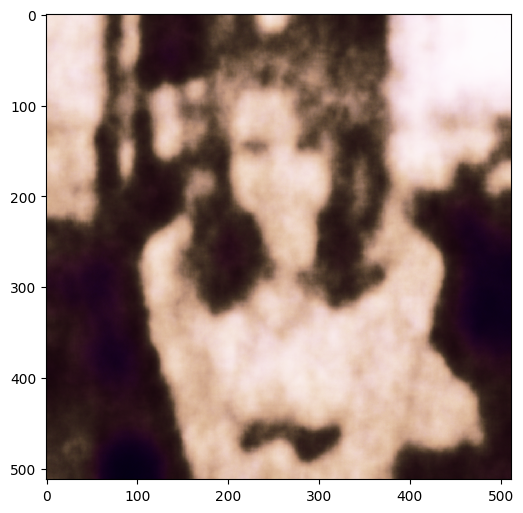

 N0 Iteration 00100    Loss 0.005718

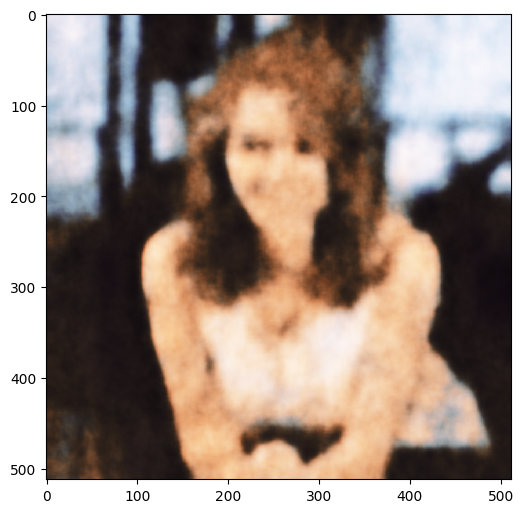

 N0 Iteration 00150    Loss 0.004758

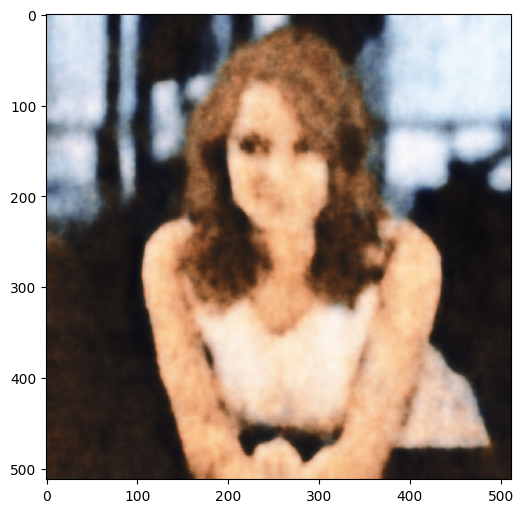

 N0 Iteration 00200    Loss 0.003429

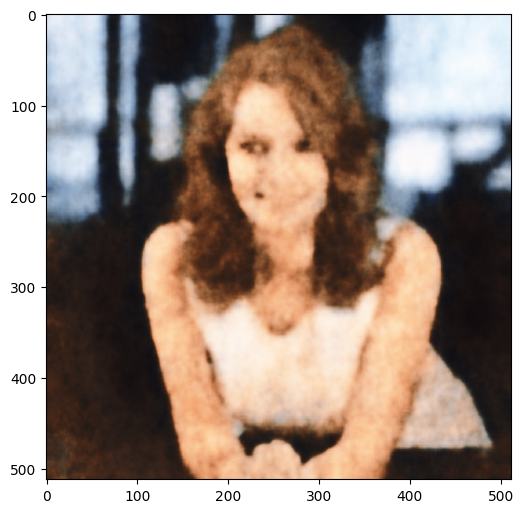

 N0 Iteration 00250    Loss 0.002817

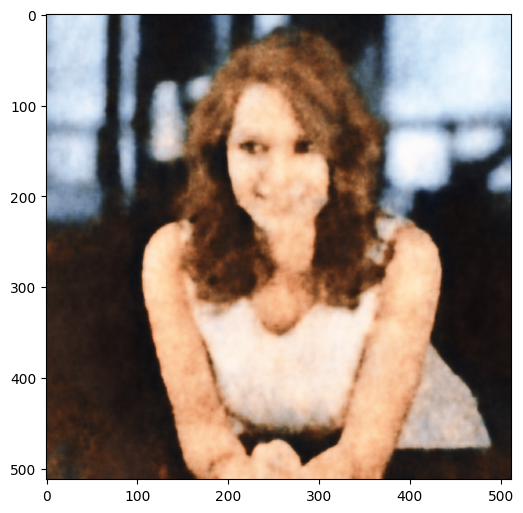

 N0 Iteration 00300    Loss 0.002229

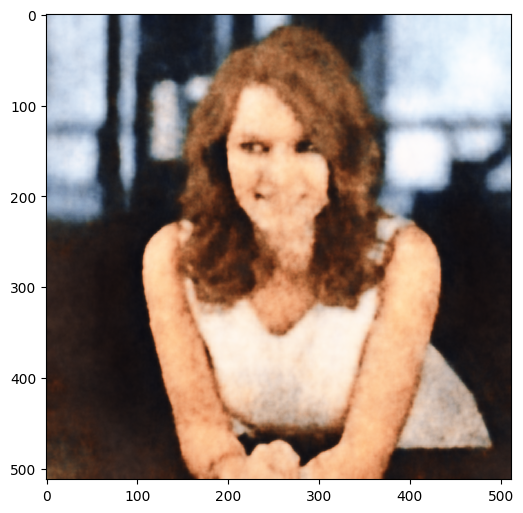

 N0 Iteration 00350    Loss 0.001793

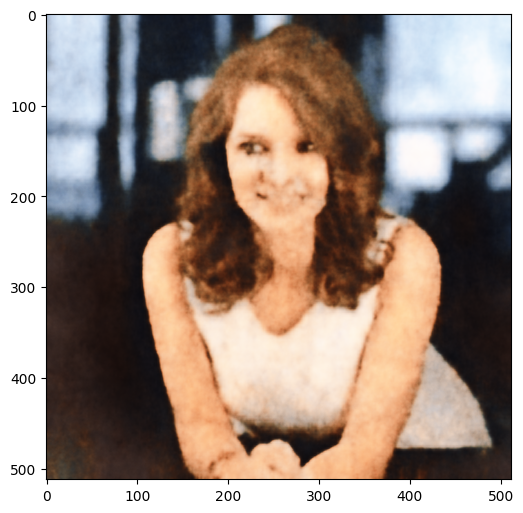

 N0 Iteration 00400    Loss 0.001665

In [ ]:
index = 0
while index < 1:

    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

    net = net.type(dtype)
    net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

    i = 0
    def closure():
        
        global i
        
        if param_noise:
            for n in [x for x in net.parameters() if len(x.size()) == 4]:
                n = n + n.detach().clone().normal_() * n.std() / 50
        
        net_input = net_input_saved
        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)
            
            
        out = net(net_input)
      
        total_loss = mse(out * mask_var, img_var * mask_var)
        total_loss.backward()
            
        print ('\r N%d Iteration %05d    Loss %f' % (index, i, total_loss.item()), end='')
        if  PLOT and i % show_every == 0:
            out_np = torch_to_np(out)
            plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
            
        i += 1

        return total_loss

    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()

    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER, p, closure, LR, num_iter)


    list_out_np.append(torch_to_np(net(net_input)))

    index += 1


In [39]:
# local runtime
pickle.dump( list_out_np, open( "projet/inpainting/list_out_np.p", "wb" ))

In [ ]:
# colab
pickle.dump( list_out_np, open( "/content/drive/MyDrive/Deep_Image_Prior/inpainting/list_out_np.p", "wb" ))

inpainting 0


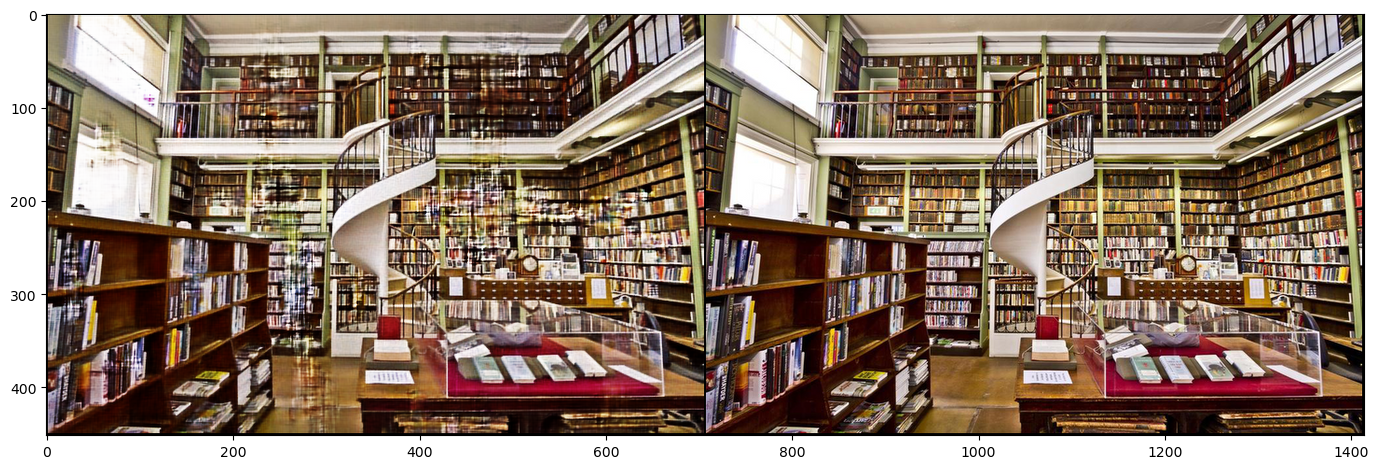

In [43]:
k=0
for out_np in list_out_np:
  print('inpainting', k)
  plot_image_grid([out_np, img_np], factor=15);
  k += 1


## Conversion Numpy -> matlab

In [ ]:
from scipy.io import savemat
savemat('projet/inpainting/outputs.mat', {'outputs': list_out_np})